# Sperm Motility Prediction with 3D ResNet18 and Tabular Data

## Installing dependencies and loading data via Google Drive in the notebook 

In [ ]:
#when running first time or system crashed.
!pip install av
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

     |████████████████████████████████| 36.9MB 81kB/s 
Mounted at /gdrive
/gdrive


## Importing neccessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.video_utils import VideoClips
from torch.utils.data.dataset import random_split
import torchvision.transforms as T
import torchvision

import os
import av
from torch.autograd import Variable
import math
from functools import partial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.utils import class_weight
from PIL import Image
from matplotlib import cm

## Preparing the datasets and loading them on the GPU

In [ ]:
os.chdir("/gdrive/My Drive/Innerve 2020/Innerve 2020/visem-dataset/dataset/videos")

In [ ]:
df = pd.read_csv("../train_test.csv")
y_train = df['class_labels']

Converting individual channels to grayscale and stacking them together to form the final video tensor in the dataset.

In [ ]:
transform = T.Compose([T.Grayscale(), T.ToTensor()])

Using tabular data which contains important features as a result of the EDA along with the videos as a datapoint.

In [ ]:
class VisemDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):      
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        video_name = str(os.path.join(self.root_dir, self.df.iloc[idx, -2]))
        video_clips = VideoClips([video_name], clip_length_in_frames=50, frames_between_clips=50)
        video_datapoint, _, info, _ = video_clips.get_clip(0)
        # print("info - ", info)
        video_datapoint = video_datapoint.numpy()
        video_tensors = []
        for i, sing_frame in enumerate(video_datapoint):
          sing_frame_image = Image.fromarray(sing_frame.astype('uint8'), 'RGB')
          sing_frame_tensor = transform(sing_frame_image)
          video_tensors.append(sing_frame_tensor.unsqueeze(0))

        video_tensor = (torch.stack(video_tensors,dim=1)).squeeze(0).permute(1, 0, 2, 3)
        # print(video_tensor.shape)

        label = self.df.iloc[idx, -1]
        label = torch.tensor(label)
        label = label.long()
        tabular_data = torch.tensor(np.float64(self.df.iloc[idx, :-2].values)).float()
        sample = (video_tensor.float(), label, tabular_data)
        return sample

In [ ]:
train_dataset = VisemDataset("../train.csv", ".")
test_dataset = VisemDataset("../test.csv", ".")

In [ ]:
torch.manual_seed(42)
val_size = 8
test_size = len(test_dataset) - val_size

test_dataset, val_dataset = random_split(test_dataset, [test_size, val_size])
len(test_dataset), len(val_dataset)

(9, 8)

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle = True, batch_size=2)
val_dataloader = DataLoader(val_dataset, shuffle = False, batch_size=1)
test_dataloader = DataLoader(test_dataset, shuffle = False, batch_size=1)

Checking if GPU is available or not

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

Loading the data into memory one batch at a time.

In [ ]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader(DataLoader):
  def __init__(self, dl, device):
      self.dl = dl
      self.device = device
      
  def __iter__(self):
      for b in self.dl: 
          yield to_device(b, self.device)

  def __len__(self):
      return len(self.dl)

In [ ]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
val_dataloader = DeviceDataLoader(val_dataloader, device)

In [ ]:
def find_accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return ((preds == labels).sum()).item() / len(preds)

Since the dataset is skewed, we are taking weighted classes to give accurate results.

In [ ]:
class_weights = to_device(torch.tensor(class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)), device)
class_weights

tensor([0.5346, 3.1481, 1.2319], device='cuda:0', dtype=torch.float64)

## Building the Model

In [ ]:
class Basic(nn.Module):
  def training_batch(self, batch):
    videos, labels, tabular_data = batch
    outputs = self.forward(videos, tabular_data)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    loss = torch.mul(class_weights, loss)
    loss= torch.mean(loss)
    return loss

  def validation_batch(self, batch):
    videos, labels, tabular_data = batch
    outputs = self.forward(videos, tabular_data)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    loss = torch.mul(class_weights, loss)
    loss= torch.mean(loss)
    accuracy = find_accuracy(outputs, labels)
    return {'val_loss' : loss.item(), 'val_accuracy' : accuracy}

  def validation_end_epoch(self, outputs):
    epoch_loss = sum([x['val_loss'] for x in outputs]) / len(outputs)
    epoch_accuracy = sum([x['val_accuracy'] for x in outputs]) / len(outputs)
    return {'epoch_loss' : epoch_loss, 'epoch_accuracy' : epoch_accuracy}



We construct a 3D ResNet18 from scratch and augment our tabular data in the fully connected layer just before our model makes a prediction by constructing an Augmented Siamese Network

In [ ]:
def conv3x3x3(in_planes, out_planes, stride=1):
    # 3x3x3 convolution with padding
    return nn.Conv3d(in_planes, out_planes, kernel_size=3,
                     stride=stride, padding=1, bias=False)


def downsample_basic_block(x, planes, stride):
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(out.size(0), planes - out.size(1),
                             out.size(2), out.size(3),
                             out.size(4)).zero_()
    if isinstance(out.data, torch.cuda.FloatTensor):
        zero_pads = zero_pads.cuda()

    out = Variable(torch.cat([out.data, zero_pads], dim=1))

    return out


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(Basic):

    def __init__(self, block, layers, shortcut_type='B', num_classes=3, last_fc=True):
        self.last_fc = last_fc
        self.data_columns = 19
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=7, stride=(1, 2, 2),
                               padding=(3, 3, 3), bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], shortcut_type)
        self.layer2 = self._make_layer(block, 128, layers[1], shortcut_type, stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], shortcut_type, stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], shortcut_type, stride=2)
        self.avgpool = nn.AvgPool3d((4, 15, 20), stride=1)
        self.fc = nn.Linear((512 * block.expansion) + self.data_columns , 84)

        self.final = nn.Linear(84, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(self.inplanes, planes * block.expansion,
                              kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm3d(planes * block.expansion)
                )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, participant_data):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        if self.last_fc:
            x = self.fc(torch.cat((x, participant_data), axis = 1))
            z = self.final(x)

        return z


def get_fine_tuning_parameters(model, ft_begin_index):
    if ft_begin_index == 0:
        return model.parameters()

    ft_module_names = []
    for i in range(ft_begin_index, 5):
        ft_module_names.append('layer{}'.format(ft_begin_index))
    ft_module_names.append('fc')

    parameters = []
    for k, v in model.named_parameters():
        for ft_module in ft_module_names:
            if ft_module in k:
                parameters.append({'params': v})
                break
        else:
            parameters.append({'params': v, 'lr': 0.0})

    return parameters

In [ ]:
model = ResNet(BasicBlock, [2, 2, 2, 2])
model = to_device(model, device)

### Model Architechture

In [ ]:
model

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

## Training

In [ ]:
def validate(model, val_ddl):
    model.eval()
    outputs = [model.validation_batch(batch) for batch in val_ddl]
    return model.validation_end_epoch(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit(model, epochs, train_ddl, val_ddl, max_learning_rate, weight_decay, grad_clip, grad_norm, optimization_func):
  torch.cuda.empty_cache()
  history=[]
  optimizer = optimization_func(model.parameters(), max_learning_rate, weight_decay=weight_decay)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_learning_rate, epochs=epochs, steps_per_epoch=len(train_ddl))
  for epoch in range(epochs):
    model.train()
    train_losses = []
    learning_rates=[]
    for batch in tqdm(train_ddl):  
      loss = model.training_batch(batch)
      train_losses.append(loss)
      loss.backward()

      if grad_clip: 
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
      if grad_norm: 
        nn.utils.clip_grad_value_(model.parameters(), grad_norm)

      optimizer.step()
      optimizer.zero_grad()

      learning_rates.append(get_lr(optimizer))
      scheduler.step()
    result = validate(model, val_dataloader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = learning_rates
    history.append(result)
    if(epoch%2!=0):
      torch.save(model.state_dict(), f'modelv3_tabular_data-{int((epoch + 5)/2)}.pth')
    print('Epoch: {}, Last LR: {:.5f}, Train loss: {:.4f}, Validation loss: {:.5f}, Validation accuracy: {:.5f}'.format(epoch, result['lrs'][-1], result['train_loss'], result['epoch_loss'], result['epoch_accuracy']))
  return history      

In [ ]:
history += fit(model, 6, train_dataloader, val_dataloader, 0.00091,1e-4, 0.1, 1.0,  torch.optim.Adam)

Text(0.5, 1.0, '3D ResNet18 with tabular data Loss vs No. of Epochs')

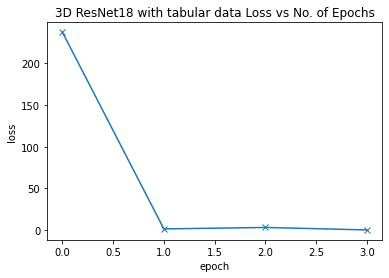

In [ ]:
losses = [x['epoch_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('3D ResNet18 with tabular data Loss vs No. of Epochs')

In [ ]:
def load_checkpoint(filepath): 
    model = ResNet(BasicBlock, [2, 2, 2, 2])
    model= to_device(model, device)
    model.load_state_dict(torch.load(filepath))
    
    return model

In [ ]:
model = load_checkpoint("modelv3_tabular_data-4.pth")

In [ ]:
test_dataloader = DeviceDataLoader(test_dataloader, device)
history_test = [validate(model, test_dataloader)]
history_test

/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."


[{'epoch_accuracy': 0.7777777777777778, 'epoch_loss': 3.6882020490016987}]